In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data-analysis/time_dim.csv
/kaggle/input/ecommerce-data-analysis/fact_table.csv
/kaggle/input/ecommerce-data-analysis/Trans_dim.csv
/kaggle/input/ecommerce-data-analysis/item_dim.csv
/kaggle/input/ecommerce-data-analysis/store_dim.csv
/kaggle/input/ecommerce-data-analysis/customer_dim.csv


# Lets Explore and Understand the Data 

In [2]:
#here we will use the sqlite3 to load the data 
import pandas as pd
import sqlite3

conn = sqlite3.connect(':memory:')

In [3]:
import csv
def load_csv_to_db(file_path, table_name):
    encodings = ['utf-8', 'ISO-8859-1', 'utf-16', 'Windows-1252']
    for encoding in encodings:
        try:
            with open(file_path, encoding=encoding) as file:
                data = list(csv.DictReader(file))
                df = pd.DataFrame(data)
                df.to_sql(table_name, conn, index=False, if_exists='replace')
                print(f"Loaded {file_path} successfully with encoding: {encoding}")
                break  # Break the loop if the file is loaded successfully
        except UnicodeDecodeError:
            print(f"UnicodeDecodeError with encoding: {encoding} for file: {file_path}")
            continue  # Try the next encoding

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(f'loading: {filename}')
        load_csv_to_db(file_path = os.path.join(dirname, filename), table_name = filename.split('_')[0])
        print(f'loaded {filename.split("_")[0]} table into db successfully')

loading: time_dim.csv
Loaded /kaggle/input/ecommerce-data-analysis/time_dim.csv successfully with encoding: utf-8
loaded time table into db successfully
loading: fact_table.csv
Loaded /kaggle/input/ecommerce-data-analysis/fact_table.csv successfully with encoding: utf-8
loaded fact table into db successfully
loading: Trans_dim.csv
Loaded /kaggle/input/ecommerce-data-analysis/Trans_dim.csv successfully with encoding: utf-8
loaded Trans table into db successfully
loading: item_dim.csv
UnicodeDecodeError with encoding: utf-8 for file: /kaggle/input/ecommerce-data-analysis/item_dim.csv
Loaded /kaggle/input/ecommerce-data-analysis/item_dim.csv successfully with encoding: ISO-8859-1
loaded item table into db successfully
loading: store_dim.csv
Loaded /kaggle/input/ecommerce-data-analysis/store_dim.csv successfully with encoding: utf-8
loaded store table into db successfully
loading: customer_dim.csv
UnicodeDecodeError with encoding: utf-8 for file: /kaggle/input/ecommerce-data-analysis/custo

In [5]:
# Function to print the first few rows of each table
def preview_table(table_name, num_rows=5):
    query = f"SELECT * FROM {table_name} LIMIT {num_rows};"
    df = pd.read_sql_query(query, conn)
    print(f"Preview of {table_name}:")
    print(df)
    print("\n")

In [6]:
def get_table_names():
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    df = pd.read_sql_query(query, conn)
    return df['name'].tolist()

# Retrieve table names from the database
table_names = get_table_names()
print("Tables in the database:", table_names)

Tables in the database: ['time', 'fact', 'Trans', 'item', 'store', 'customer']


In [7]:
# Preview each table
for table in table_names:
    preview_table(table)

Preview of time:
  time_key              date hour day      week month quarter  year
0   T00001  20-05-2017 14:56   14  20  3rd Week    05      Q2  2017
1   T00002  30-01-2015 22:14   22  30  4th Week    01      Q1  2015
2   T00003  14-03-2020 02:34   02  14  2nd Week    03      Q1  2020
3   T00004  27-04-2018 12:19   12  27  4th Week    04      Q2  2018
4   T00005  14-04-2018 10:43   10  14  2nd Week    04      Q2  2018


Preview of fact:
  payment_key coustomer_key time_key item_key store_key quantity   unit  \
0        P026       C004510  T049189   I00177    S00307        1     ct   
1        P022       C008967  T041209   I00248    S00595        1  rolls   
2        P030       C007261   T03633   I00195    S00496        8     ct   
3        P032       C007048  T084631   I00131     S0086        8     ct   
4        P014       C006430  T071276   I00050    S00488        8   cans   

  unit_price total_price  
0         35          35  
1         26          26  
2       12.5         100

# Sales Trends Over Time

In [8]:
query = """
SELECT t.year, t.month, SUM(f.total_price) as total_sales
FROM fact f
JOIN time t ON f.time_key = t.time_key
GROUP BY t.year, t.month
ORDER BY t.year, t.month;
"""

# Execute the query using pandas
result_df = pd.read_sql_query(query, conn)

# Display the result
print(result_df)



    year month  total_sales
0   2014    01    496549.25
1   2014    02   1122547.00
2   2014    03   1262435.75
3   2014    04   1245142.50
4   2014    05   1268770.50
..   ...   ...          ...
80  2020    09   1232639.75
81  2020    10   1319655.75
82  2020    11   1200248.75
83  2020    12   1346884.75
84  2021    01    883772.25

[85 rows x 3 columns]


In [9]:
import plotly.express as px
# Convert 'year' and 'month' to a datetime object for plotting
result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(DAY=1))

# Create an interactive line plot
fig = px.line(result_df, x='date', y='total_sales', 
              title='Sales Trend Over Time', 
              labels={'date': 'Date', 'total_sales': 'Total Sales'})

# Enhance the layout
fig.update_layout(xaxis_title='Date', yaxis_title='Total Sales',
                  xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))

# Show the plot
fig.show()

The graph represents a time series of total sales from January 2014 to January 2021. Over these seven years, the sales figures show variability month-to-month, with no clear long-term upward or downward trend until the end of the observed period.

Throughout the period from 2014 to 2020, the sales figures fluctuate regularly, indicating a pattern that might correspond to seasonal trends or specific business cycles. For example, there might be peaks that correspond to holiday seasons or sales events, and troughs that might align with traditionally slower sales periods.

Notably, the sales figures consistently stay above approximately 1.2 million units, suggesting a steady demand for the products or services offered. Peaks in sales, such as those exceeding 1.3 million units, could be indicative of successful marketing campaigns, periods of increased consumer spending, or the introduction of popular products.

However, a significant drop is observed in January 2021, where sales fall below 900,000 units. This sudden decrease deviates from the previous years' patterns and could be a sign of a critical event or change impacting the business. Potential factors could include economic downturns, changes in consumer behavior, increased competition, or internal company challenges.

# Product Performance

In [10]:
query = """
SELECT i.item_name, SUM(f.quantity) as total_quantity_sold
FROM fact f
JOIN item i ON f.item_key = i.item_key
GROUP BY i.item_name
ORDER BY total_quantity_sold DESC;
"""

product_performance = pd.read_sql_query(query, conn)

print(product_performance)

                               item_name  total_quantity_sold
0                     Pepsi - 12 oz cans                46837
1    Muscle Milk Protein Shake Van. 11oz                45665
2                Coke Classic 12 oz cans                45501
3                 Diet Coke - 12 oz cans                45202
4                    Sprite - 12 oz cans                45140
..                                   ...                  ...
254        Dole Fruit in Gel Cups 4.3 oz                21818
255      La Croix Sparkling Orange 12 oz                21817
256        Hershey Factory Favorites Mix                21741
257                   Monster Java 15 oz                21698
258               Snyders Pretzels Minis                21647

[259 rows x 2 columns]


In [11]:
fig = px.bar(product_performance, 
             x='total_quantity_sold', 
             y='item_name', 
             orientation='h', # horizontal bar chart
             title='Product Performance: Quantity Sold per Item')

fig.update_layout(xaxis_title='Total Quantity Sold', 
                  yaxis_title='Item Name',
                  yaxis=dict(showgrid=False, categoryorder='total ascending'), # combine yaxis settings
                  xaxis=dict(showgrid=False))

# Show the plot
fig.show()

**Top Performers:** The leading products in terms of quantity sold are *'Pepsi - 12 oz cans'*, followed closely by *'Muscle Milk Protein Shake Van. 11oz'*, *'Coke Classic 12 oz cans'*, *'Diet Coke - 12 oz cans'*, and *'Sprite - 12 oz cans'*. These items seem to have significantly higher sales volumes compared to the rest, indicating a strong customer preference or effective sales strategies for these products.

**Product Variety:** The range of products is quite diverse, including soft drinks, protein shakes, sugar canisters, peanut butter cups, and more, suggesting a broad inventory appealing to varied customer tastes and needs.

**Sales Distribution:** The sales distribution is relatively uneven, with a sharp drop-off as we move down the list of products. While a few items have very high sales, the majority have moderate to lower sales volumes.

**Potential Focus Areas:** The high sales of certain beverages like Pepsi and Coke suggest that soft drinks are popular items, potentially driving a significant portion of the revenue. This might be an area for the store to focus on for promotions or inventory management.

**Sales Strategy Insights:** The data might be used to optimize inventory by ensuring that top-selling products are always in stock, while re-evaluating the carrying costs of the lower-selling items.

# Customer Analysis

In [12]:
query = """
SELECT c.name, COUNT(*) as number_of_purchases, SUM(f.total_price) as total_spent
FROM fact f
JOIN customer c ON f.coustomer_key = c.coustomer_key
GROUP BY c.name
ORDER BY total_spent DESC;

"""

customer_analysis = pd.read_sql_query(query, conn)

print(customer_analysis)

                name  number_of_purchases  total_spent
0              pooja                20173   2109800.75
1              jyoti                12696   1331696.25
2               neha                 9419    996121.00
3             sunita                 8648    915543.75
4             poonam                 8727    914285.25
...              ...                  ...          ...
4530  ahsamin @ juhi                   77      7554.25
4531      smt sujata                   83      7496.25
4532         meenaxi                   79      7113.50
4533         bahwana                   83      7105.50
4534           purva                   76      7081.75

[4535 rows x 3 columns]


In [13]:
top_n = 20
top_customers = customer_analysis.head(top_n)

fig = px.bar(top_customers, x='name', y='total_spent', 
             title=f'Top {top_n} Customers by Total Spent')
fig.update_layout(xaxis_title='Customer', yaxis_title='Total Spent')
fig.show()

In [14]:
fig = px.histogram(customer_analysis, x='total_spent',
                   title='Distribution of Total Spent by Customers',
                   nbins=50)  # Adjust the number of bins as needed
fig.update_layout(xaxis_title='Total Spent', yaxis_title='Count of Customers')
fig.show()

In [15]:
fig = px.scatter(customer_analysis, x='number_of_purchases', y='total_spent', 
                 hover_name='name', title='Number of Purchases vs Total Spent by Customers')
fig.update_layout(xaxis_title='Number of Purchases', yaxis_title='Total Spent')
fig.show()

In [16]:
customer_analysis_sorted = customer_analysis.sort_values('total_spent', ascending=False)
customer_analysis_sorted['cumulative_spent'] = customer_analysis_sorted['total_spent'].cumsum()
customer_analysis_sorted['cumulative_percentage'] = 100 * customer_analysis_sorted['cumulative_spent'] / customer_analysis_sorted['total_spent'].sum()

fig = px.line(customer_analysis_sorted, y='cumulative_percentage', 
              title='Cumulative Distribution of Total Spent by Customers')
fig.update_layout(xaxis_title='Number of Customers', yaxis_title='Cumulative Percentage of Total Spent')
fig.update_xaxes(range=[0, top_n])  # Adjust the range as needed
fig.show()

**Cumulative Distribution of Total Spent by Customers**

This line graph shows that a small number of customers account for a large percentage of the total spending. This kind of distribution is typical of a *Pareto principle (or 80/20 rule)* where the majority of sales come from a minority of customers. This indicates that the business might rely on a core group of high-spending customers.

**Number of Purchases vs Total Spent by Customers**

The scatter plot suggests a positive correlation between the number of purchases and the total amount spent, which is to be expected. However, there are customers with a high number of purchases but relatively lower total spending, indicating they may be buying less expensive items more frequently. Conversely, there are customers with fewer purchases but higher spending, possibly indicating larger transactions or the purchase of higher-priced items.

**Distribution of Total Spent by Customers**

The histogram shows that most customers spend in the lower monetary range, with a very steep drop-off as spending amounts increase. This further indicates that there are only a few high-spending customers, while the majority spend much less.

**Top 20 Customers by Total Spent**

The bar chart of the top 20 customers by total spent clearly shows that the top customer, Pooja, has a significantly higher total spending than the others. There is a gradual decline in spending among the remaining top customers. This reinforces the importance of the top spenders to the overall sales and may suggest that personalized marketing strategies or loyalty programs could be effective for maintaining their engagement.

**Overall Summary**

The customer analysis data and the visualizations suggest that the business has a wide range of customers, but is heavily supported by a small segment of high-value customers. The company might benefit from strategies aimed at increasing the spend of lower-tier customers while maintaining the loyalty of the top-tier ones. Understanding the purchasing patterns and preferences of these key segments could drive targeted marketing campaigns, personalized promotions, and tailored product recommendations to enhance customer value across the board.

Given the importance of the top spending customers, a customer relationship management (CRM) strategy could be particularly effective. Additionally, analyzing the data to understand the factors influencing the higher number of transactions and the high-value purchases could provide actionable insights for business growth and customer satisfaction improvement.

# Store Performance by Location

In [17]:
query = """
SELECT s.division, s.district, SUM(f.total_price) as sales
FROM fact f
JOIN store s ON f.store_key = s.store_key
GROUP BY s.division, s.district
ORDER BY sales DESC;
"""

store_perf_by_loc = pd.read_sql_query(query, conn)
print(store_perf_by_loc)

      division    district        sales
0        DHAKA       DHAKA  23597621.00
1   CHITTAGONG  CHITTAGONG   7292985.50
2       KHULNA      KHULNA   4081283.75
3     RAJSHAHI    RAJSHAHI   3756454.50
4      BARISAL     BARISAL   2897237.75
..         ...         ...          ...
59      KHULNA      MAGURA    577543.25
60     BARISAL   JHALOKATI    570807.25
61      KHULNA   CHUADANGA    563909.75
62      KHULNA      NARAIL    440698.75
63      KHULNA    MEHERPUR    436755.00

[64 rows x 3 columns]


In [18]:
fig = px.treemap(store_perf_by_loc, path=['division', 'district'], values='sales',
                 title='Store Performance by Division and District')
fig.show()

In [19]:
top_n = 20
top_locations = store_perf_by_loc.head(top_n)

fig = px.bar(top_locations, x='sales', y='division', 
             title=f'Top {top_n} Performing Divisions and Districts by Sales')
fig.update_layout(xaxis_title='Sales', yaxis_title='Division - District')
fig.show()

In [20]:
fig = px.bar(store_perf_by_loc, x='division', y='sales', color='district',
             title='Sales Breakdown by Division and District')
fig.update_layout(xaxis_title='Division', yaxis_title='Sales')
fig.show()

**Sales Breakdown by Division and District**

The stacked bar chart illustrates the sales distribution across various divisions and their constituent districts. Dhaka division, with Dhaka district in particular, dominates the sales figures, indicating a strong market presence or consumer base in the capital region. The chart also displays the sales contributions from other divisions like Chittagong and Khulna, which are substantial but significantly lower than Dhaka.

**Top 20 Performing Divisions and Districts by Sales**

The bar chart ranking the top-performing divisions and districts emphasizes the disproportionate sales volume generated by Dhaka. It suggests a steep gradient in sales performance, with each subsequent division contributing a smaller fraction to the total sales. This chart underscores the importance of the Dhaka market to the business's success.

**Store Performance by Division and District**

The treemap provides a visual summary of the sales performance, with the size of each block representing the sales volume of a district within its division. Dhaka's district is prominently the largest, while other divisions such as Chittagong, Rajshahi, Barisal, and Sylhet are relatively smaller yet notable contributors.

**Overall Summary**

Across the visualizations, it's clear that the business's performance is heavily skewed towards the Dhaka division, and within it, primarily the Dhaka district, which could be due to a larger customer base, higher population density, or greater store presence. The significant drop in sales volume outside of Dhaka suggests a potential for growth in other divisions. Strategies such as targeted marketing, expansion of store locations, or localized promotions might be effective in tapping into the sales potential of other districts.

The visualizations also highlight that while Dhaka is the key market, other regions contribute meaningfully to the sales diversity. It's crucial for the business to understand the dynamics of the Dhaka market to sustain its dominance while also crafting tailored approaches to bolster sales in other divisions.

The data implies that the business may benefit from diversifying its presence and investing in growth opportunities outside of the Dhaka division to mitigate the risk of over-reliance on a single market. Understanding the customer demographics, preferences, and spending power in each division and district will be key to crafting successful regional strategies.

# Payment Method Preferences

In [21]:
query = """
SELECT p.trans_type, COUNT(*) as transaction_count, SUM(f.total_price) as total_amount
FROM fact f
JOIN trans p ON f.payment_key = p.payment_key
GROUP BY p.trans_type
ORDER BY transaction_count DESC;
"""

payment_method_preferences = pd.read_sql_query(query, conn)

print(payment_method_preferences)

  trans_type  transaction_count  total_amount
0       card             897319   94583038.50
1     mobile              77091    8109881.50
2       cash              25590    2708515.75


In [22]:
fig = px.bar(payment_method_preferences, x='trans_type', y='transaction_count',
             title='Transaction Count by Payment Method')
fig.update_layout(xaxis_title='Payment Method', yaxis_title='Transaction Count')
fig.show()

In [23]:
# Pie chart for transaction count
fig = px.pie(payment_method_preferences, names='trans_type', values='transaction_count',
             title='Proportion of Transactions by Payment Method')
fig.show()

# Pie chart for total amount
fig = px.pie(payment_method_preferences, names='trans_type', values='total_amount',
             title='Proportion of Total Amount by Payment Method')
fig.show()

**Proportion of Total Amount by Payment Method**

The pie chart shows a dominant preference for *card payments*, accounting for almost **90%** of the total amount spent. *Mobile payments* and cash are used far less frequently, with mobile payments making up approximately **7.69%** and *cash transactions* only about **2.5%**. This indicates a strong consumer inclination towards card transactions for their purchases.

**Proportion of Transactions by Payment Method**

A similar distribution is observed in the second pie chart for the proportion of transactions by payment method, with card transactions leading significantly. This suggests that not only do customers prefer to spend more when using cards, but they also tend to make a higher number of transactions with cards.

**Transaction Count by Payment Method**

The bar chart further emphasizes the dominance of card payments in terms of transaction count, with card transactions vastly outnumbering those of mobile payments and cash. The card transactions are the most favored method, suggesting ease of use, possible rewards incentives, customer habits, or a broader shift towards digital payment solutions.

**Overall Summary**

The data and visualizations collectively illustrate a clear preference for card payments among customers, both in terms of the total monetary amount and the number of transactions. This trend reflects a consumer shift towards cashless transactions, which could be driven by the convenience of cards, the rise of online shopping, or the availability of card-based loyalty points and rewards.

Mobile payments, while significantly less than card payments, still represent a notable portion of transactions, indicating that a segment of the customer base is engaged with digital and mobile payment platforms. Cash, while the least utilized method, still maintains a presence, highlighting that some customer segments may prefer traditional payment methods or that there are transactions where cash is necessary or more convenient.

For the business, this information could be crucial for tailoring payment options to customer preferences, potentially streamlining operations, and maybe even incentivizing certain payment methods. The heavy preference for card payments suggests that ensuring a smooth and secure card transaction process could enhance customer satisfaction and potentially increase sales. The data might also inform decisions around whether to invest in infrastructure to support emerging payment technologies, like mobile wallets, to cater to the tech-savvy consumer segment.

# Time of Day Analysis

In [24]:
query = """
SELECT t.hour, COUNT(*) as number_of_transactions, SUM(f.total_price) as total_sales
FROM fact f
JOIN time t ON f.time_key = t.time_key
GROUP BY t.hour
ORDER BY total_sales DESC;

"""

time_of_day_analysis = pd.read_sql_query(query, conn)

print(time_of_day_analysis)

   hour  number_of_transactions  total_sales
0    14                   43206   4576237.50
1    19                   42992   4548869.00
2    17                   42672   4497724.50
3    13                   42657   4475946.00
4    09                   42348   4472149.75
5    10                   42268   4459400.50
6    21                   41970   4448638.50
7    12                   42101   4427233.25
8    15                   41925   4409550.25
9    23                   41620   4407222.25
10   05                   41858   4404697.75
11   02                   41756   4402569.25
12   07                   41909   4397288.75
13   03                   41682   4379149.75
14   18                   41435   4371271.50
15   16                   41059   4346857.75
16   22                   41218   4317362.75
17   08                   41084   4315875.25
18   01                   40922   4313828.00
19   20                   41147   4309155.00
20   00                   40784   4293368.00
21   11   

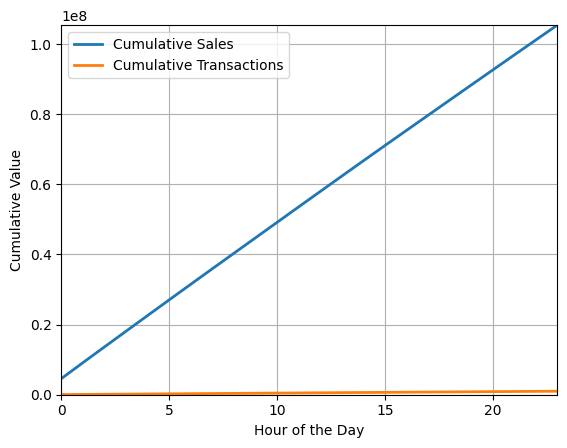

In [25]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# Preparing the DataFrame
time_of_day_analysis['cumulative_sales'] = time_of_day_analysis['total_sales'].cumsum()
time_of_day_analysis['cumulative_transactions'] = time_of_day_analysis['number_of_transactions'].cumsum()

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line1, = ax.plot([], [], lw=2, label='Cumulative Sales')
line2, = ax.plot([], [], lw=2, label='Cumulative Transactions')
ax.set_xlim(0, 23)
ax.set_ylim(0, max(time_of_day_analysis['cumulative_sales'].max(), 
                   time_of_day_analysis['cumulative_transactions'].max()))
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Cumulative Value')
ax.legend()
ax.grid()

# Initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,

# Animation function: this is called sequentially
def animate(hour):
    x = time_of_day_analysis.index[:hour+1]
    y1 = time_of_day_analysis['cumulative_sales'][:hour+1]
    y2 = time_of_day_analysis['cumulative_transactions'][:hour+1]
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    return line1, line2,

# Call the animator
anim = FuncAnimation(fig, animate, init_func=init, frames=24, interval=200, blit=True)

# To show the animation inline in Jupyter Notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

In [26]:
fig = px.bar(time_of_day_analysis, x='hour', y=['total_sales', 'number_of_transactions'],
             title='Comparative Analysis of Sales and Transactions by Hour of the Day')
fig.update_layout(xaxis_title='Hour of the Day', yaxis_title='Sales / Transactions Count', barmode='group')
fig.show()


In [27]:
time_of_day_analysis['cumulative_sales'] = time_of_day_analysis['total_sales'].cumsum()

fig = px.area(time_of_day_analysis, x='hour', y='cumulative_sales', 
              title='Cumulative Sales by Hour of the Day')
fig.update_layout(xaxis_title='Hour of the Day', yaxis_title='Cumulative Sales', xaxis=dict(tickmode='linear'))
fig.show()

# Correlation Between Sales and Other Factors

In [28]:
query = """
SELECT i.desc, s.division, SUM(f.total_price) as sales
FROM fact f
JOIN item i ON f.item_key = i.item_key
JOIN store s ON f.store_key = s.store_key
GROUP BY i.desc, s.division
ORDER BY sales DESC;
"""

corr_sales_and_other = pd.read_sql_query(query, conn)
print(corr_sales_and_other)

                          desc division      sales
0               Food - Healthy    DHAKA  3993300.0
1    Beverage - Energy/Protein    DHAKA  3964704.0
2             Kitchen Supplies    DHAKA  3248517.5
3                 Food - Chips    DHAKA  2980093.0
4                Coffee K-Cups    DHAKA  2907153.0
..                         ...      ...        ...
205          Coffee K-Cups Tea   KHULNA    21213.0
206            Coffee Stirrers   SYLHET    20332.0
207          Coffee K-Cups Tea  RANGPUR    13995.0
208          Coffee K-Cups Tea  BARISAL    13446.0
209          Coffee K-Cups Tea   SYLHET    11286.0

[210 rows x 3 columns]


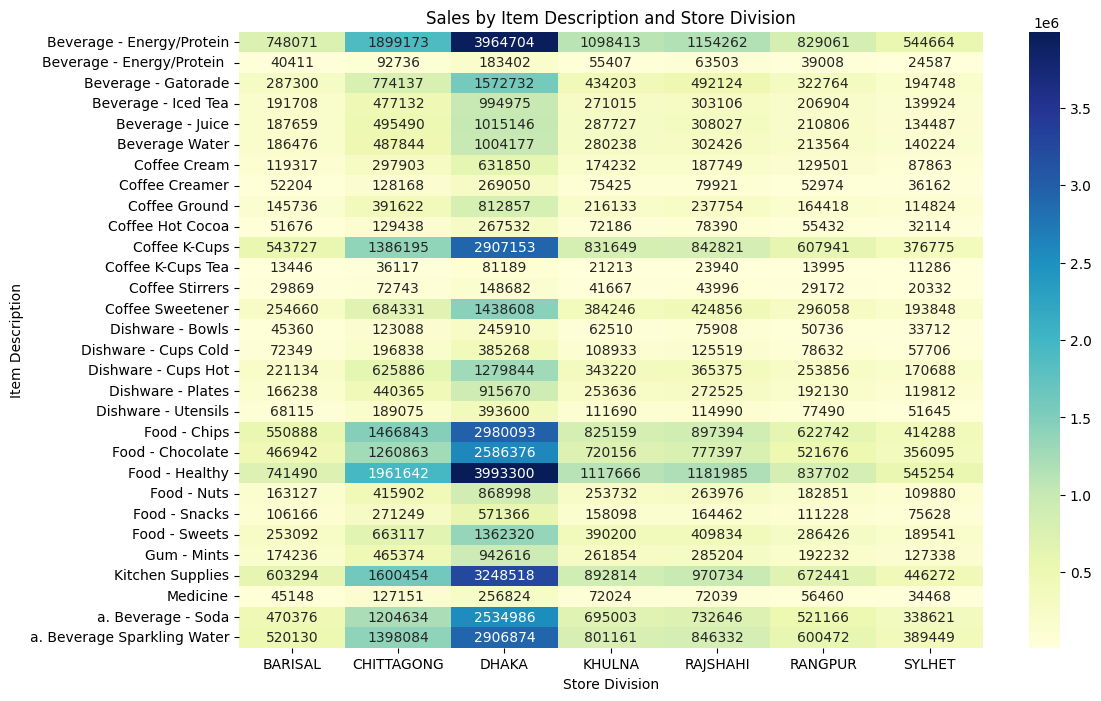

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Pivot the data for the heatmap
heatmap_data = pd.pivot_table(corr_sales_and_other, values='sales', index='desc', columns='division', aggfunc='sum')

# Create the heatmap
plt.figure(figsize=(12, 8))  # You might need to adjust the size for better visibility
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales by Item Description and Store Division")
plt.ylabel('Item Description')
plt.xlabel('Store Division')
plt.show()

In [30]:
heatmap_data

division,BARISAL,CHITTAGONG,DHAKA,KHULNA,RAJSHAHI,RANGPUR,SYLHET
desc,,,,,,,
Beverage - Energy/Protein,748071.00,1899173.00,3964704.00,1098413.00,1154262.0,829061.0,544664.00
Beverage - Energy/Protein,40411.00,92736.00,183402.00,55407.00,63503.0,39008.0,24587.00
Beverage - Gatorade,287300.00,774137.00,1572732.50,434203.00,492124.5,322764.0,194747.50
Beverage - Iced Tea,191708.25,477132.25,994975.25,271015.25,303106.0,206904.0,139923.50
Beverage - Juice,187659.00,495490.00,1015146.00,287727.00,308027.0,210806.0,134487.00
Beverage Water,186476.50,487844.00,1004177.00,280238.00,302426.5,213563.5,140224.50
Coffee Cream,119317.00,297903.00,631850.00,174232.00,187749.0,129501.0,87863.00
Coffee Creamer,52203.50,128168.50,269049.50,75425.00,79921.0,52974.5,36162.00
Coffee Ground,145735.50,391622.50,812857.00,216133.00,237754.5,164418.0,114824.00


In [31]:
fig = px.treemap(corr_sales_and_other, path=['desc', 'division'], values='sales',
                 title='Sales Distribution across Items and Divisions')
fig.show()

In [32]:
fig = px.scatter(corr_sales_and_other, x="desc", y="division", size="sales",
                 title="Sales Distribution as Bubble Chart")
fig.update_layout(xaxis_title='Item Description', yaxis_title='Division')
fig.show()

**Sales by Item Description and Store Division**

The heatmap shows a detailed breakdown of sales by item and store division. It is immediately apparent that certain items, such as 'Food - Healthy' and 'Beverage - Energy/Protein', have high sales volumes across multiple divisions, with particularly strong performance in the Dhaka division. This suggests that these items are popular and widely consumed, making them key products for the business.

**Sales Distribution as Bubble Chart**

The bubble chart provides a visual representation of the sales distribution across different divisions and items. Larger bubbles indicate higher sales volumes. Dhaka division again stands out, with larger bubbles across various item categories, signifying higher sales in this region. This visualization also allows for a comparison between divisions and the popularity of specific items within those divisions.

**Sales Distribution across Items and Divisions**

The treemap visualization further emphasizes the disproportionate sales contribution from the Dhaka division across a variety of item categories. It appears that Dhaka not only has a higher concentration of sales overall but also a diverse range of products contributing to its sales figures.

**Overall Summary**

The sales data and visualizations collectively suggest a market where the Dhaka division dominates in terms of sales volume across a broad range of product categories. This could be due to a larger customer base, higher population density, or a concentration of wealth in this region.

The strong performance of certain items such as healthy foods and energy/protein beverages indicates a consumer preference for these products, potentially driven by health consciousness or lifestyle choices.

The visual disparity in sales across divisions suggests the potential for growth in other regions. There may be opportunities to increase market penetration in divisions outside of Dhaka by tailoring marketing strategies to local preferences and increasing distribution channels.

For the business, understanding the reasons behind the popularity of certain items and the dominance of specific divisions could inform strategic decisions around inventory stocking, promotional efforts, and expansion planning. Additionally, the diversity in product popularity suggests that a one-size-fits-all approach may not be effective; instead, a tailored strategy that considers regional preferences and purchasing power could be more successful.

The data indicates that while the business has strongholds in certain areas and with certain products, there is room for strategic initiatives to capitalize on untapped market potential in other divisions and with less popular items.

In [33]:
from IPython.display import display, HTML, Image

# Replace the LinkedIn URL with your own profile's URL
linkedin_profile_url = "https://www.linkedin.com/in/venkateshtantravahi/"

# HTML code for the image and button
html_code = f"""
<html>
<body>
Thank you for your time and attention during this analysis. Let's stay connected!
<div style="text-align: center;">
<a href="{linkedin_profile_url}" target="_blank">
<button style='color: white; background-color: #0072b1; padding: 10px 20px; border-radius: 5px; border: none; cursor: pointer;'>
Follow me on LinkedIn
</button>
</a>
</div>
</body>
</html>
"""

# Display the image and button in the notebook
display(HTML(html_code))